In [2]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from scipy.interpolate import griddata
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cmocean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.initializers import Constant
from sklearn.metrics import mean_squared_error
from pandas import Timestamp
from datetime import datetime

In [3]:
# import data
# we have data from ten years in a monthly resolution and a grid with dimensions 1442x1021
data_2009 = pd.read_pickle('../data/2009_df.pkl')
data_2010 = pd.read_pickle('../data/2010_df.pkl')
data_2011 = pd.read_pickle('../data/2011_df.pkl')
data_2012 = pd.read_pickle('../data/2012_df.pkl')
data_2013 = pd.read_pickle('../data/2013_df.pkl')
data_2014 = pd.read_pickle('../data/2014_df.pkl')
data_2015 = pd.read_pickle('../data/2015_df.pkl')
data_2016 = pd.read_pickle('../data/2016_df.pkl')
data_2017 = pd.read_pickle('../data/2017_df.pkl')
data_2018 = pd.read_pickle('../data/2018_df.pkl')

In [4]:
data_2009 = data_2009[data_2009['tmask'] == 1]
data_2010 = data_2010[data_2010['tmask'] == 1]
data_2011 = data_2011[data_2011['tmask'] == 1]
data_2012 = data_2012[data_2012['tmask'] == 1]
data_2013 = data_2013[data_2013['tmask'] == 1]
data_2014 = data_2014[data_2014['tmask'] == 1]
data_2015 = data_2015[data_2015['tmask'] == 1]
data_2016 = data_2016[data_2016['tmask'] == 1]
data_2017 = data_2017[data_2017['tmask'] == 1]
data_2018 = data_2018[data_2018['tmask'] == 1]

data_2009['month'] = data_2009['time_counter'].apply(lambda x: x.month)
data_2009['year'] = 1

data_2010['month'] = data_2010['time_counter'].apply(lambda x: x.month)
data_2010['year'] = 2

data_2011['month'] = data_2011['time_counter'].apply(lambda x: x.month)
data_2011['year'] = 3

data_2012['month'] = data_2012['time_counter'].apply(lambda x: x.month)
data_2012['year'] = 4

data_2013['month'] = data_2013['time_counter'].apply(lambda x: x.month)
data_2013['year'] = 5

data_2014['month'] = data_2014['time_counter'].apply(lambda x: x.month)
data_2014['year'] = 6

data_2015['month'] = data_2015['time_counter'].apply(lambda x: x.month)
data_2015['year'] = 7

data_2016['month'] = data_2016['time_counter'].apply(lambda x: x.month)
data_2016['year'] = 8

data_2017['month'] = data_2017['time_counter'].apply(lambda x: x.month)
data_2017['year'] = 9

data_2018['month'] = data_2018['time_counter'].apply(lambda x: x.month)
data_2018['year'] = 10


data_2009.head()


# shuffle order of dataset
# data_2018 = data_2018.sample(frac=1)
# data_2009 = data_2009.sample(frac=1)

,y,x,time_counter,nav_lat,nav_lon,time_centered,SST,tmask,e1t,e2t,...,stress_X,stress_Y,currents_X,currents_Y,fco2_pre,fco2,co2flux_pre,co2flux,month,year
21636,1,361,2009-01-16 12:00:00,-76.954163,163.0,2009-01-16 12:00:00,0.875423,1,6275.24707,6275.24707,...,0.005238,0.036531,-0.023435,0.020985,220.795700,278.085388,1.303482,2.220755,1,1
21637,1,361,2009-02-15 00:00:00,-76.954163,163.0,2009-02-15 00:00:00,-1.474086,1,6275.24707,6275.24707,...,0.009059,0.048724,-0.153221,0.169094,218.434723,280.799316,1.635353,2.658472,2,1
21638,1,361,2009-03-16 12:00:00,-76.954163,163.0,2009-03-16 12:00:00,-1.788666,1,6275.24707,6275.24707,...,0.017897,0.041689,-0.129985,0.133991,243.666092,315.191711,0.776137,1.409649,3,1
21639,1,361,2009-04-16 00:00:00,-76.954163,163.0,2009-04-16 00:00:00,-1.763591,1,6275.24707,6275.24707,...,0.075618,0.146773,-0.086687,0.067823,270.999817,349.137085,0.712214,2.297483,4,1
21640,1,361,2009-05-16 12:00:00,-76.954163,163.0,2009-05-16 12:00:00,-1.794041,1,6275.24707,6275.24707,...,0.025754,0.027809,-0.035030,0.030513,277.172272,355.905670,0.040586,0.464712,5,1


In [5]:
data = pd.concat([data_2009,data_2010,data_2011,data_2012,data_2013,data_2014,data_2015,data_2016,data_2017], ignore_index=True)

In [6]:
data = data.sample(frac=1)
data.head()

,y,x,time_counter,nav_lat,nav_lon,time_centered,SST,tmask,e1t,e2t,...,stress_X,stress_Y,currents_X,currents_Y,fco2_pre,fco2,co2flux_pre,co2flux,month,year
8686138,677,869,2009-11-16 00:00:00,40.291039,-70.180695,2009-11-16 00:00:00,18.385372,1,21184.968750,19700.216797,...,-0.023706,-0.052168,0.000000,0.000000,245.532272,324.682556,2.174862,3.643408,11,1
74660196,794,435,2015-01-16 12:00:00,60.655655,-177.147217,2015-01-16 12:00:00,3.475057,1,15618.190430,16465.156250,...,-0.073801,-0.082366,-0.029806,0.071490,257.860718,367.121521,1.989665,2.271173,1,7
40141446,572,268,2012-07-16 12:00:00,18.186678,139.750000,2012-07-16 12:00:00,30.292822,1,26410.986328,26410.986328,...,-0.015668,0.010237,-0.028825,-0.014109,292.288208,394.044830,-0.360109,-0.326559,7,4
19161263,639,921,2010-12-16 12:00:00,33.154823,-57.025581,2010-12-16 12:00:00,21.480856,1,23283.085938,22955.025391,...,0.155538,0.041955,0.112116,0.017187,244.476715,327.668762,3.283520,5.261393,12,2
63947793,821,1102,2014-10-16 12:00:00,64.263756,-8.012470,2014-10-16 12:00:00,5.253076,1,15106.387695,15991.140625,...,-0.048155,0.018944,0.055562,-0.101175,249.983658,348.865753,2.358506,3.379952,10,6


In [29]:
month_to_predict = 5
training_data = data[:10000000]
test_data = data_2018
feature_to_predict = 'fco2_pre' #,'fco2','co2flux_pre','co2flux'

# reduce test data to specific month
test_data = test_data[test_data['month'] == month_to_predict]

# reduce to relevant features
test_input = test_data[['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month','year']]
test_target = test_data[[feature_to_predict]]

training_input = training_data[['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month','year']]
training_target = training_data[['fco2_pre']]

# take everything else as training and validation data
X = training_input
Y = training_target


# Initialize MinMaxScaler
# scaler = MinMaxScaler()

# Apply normalization
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# test_input = pd.DataFrame(scaler.transform(test_input), columns=test_input.columns)

In [33]:
model = Sequential([
    Dense(128, input_dim=14, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    # Dropout(0.2),
    
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='linear',kernel_initializer='zeros',bias_initializer=Constant(270))  # Output layer for regression
])

lr = 0.0002
loss_function= 'mse'

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=loss_function,
    metrics=['mae']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,017 (273.50 KB)

 Trainable params: 68,993 (269.50 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [34]:
# Set number of epochs, batch size and learning rate:
n_epochs = 20
batch_size = 2048

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    X, 
    Y, 
    epochs=n_epochs,             # Increased epochs for better convergence
    batch_size=batch_size,          # Batch size
    validation_split=0.2,   # Use 20% of data for validation
    callbacks=[early_stopping, lr_scheduler]  # Early stopping and LR scheduler
)

Epoch 1/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - loss: 478.7477 - mae: 15.0879 - val_loss: 126.3347 - val_mae: 7.7385 - learning_rate: 2.0000e-04
Epoch 2/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 146.1855 - mae: 8.4587 - val_loss: 108.2879 - val_mae: 6.9825 - learning_rate: 2.0000e-04
Epoch 3/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 122.0617 - mae: 7.6779 - val_loss: 87.0085 - val_mae: 6.3052 - learning_rate: 2.0000e-04
Epoch 4/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 108.7553 - mae: 7.2247 - val_loss: 78.4695 - val_mae: 5.9665 - learning_rate: 2.0000e-04
Epoch 5/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 100.1748 - mae: 6.9251 - val_loss: 73.1003 - val_mae: 5.7595 - learning_rate: 2.0000e-04
Epoch 6/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 93.9998 - mae: 6.6996 - val_loss: 69.7522 - val_mae: 5.5669 - learning_rate: 2.0000e-04
Epoch 7/20
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - loss: 89.2491 - mae: 6

In [35]:
# run model on test data
test_pred = model.predict(test_input)
# add prediction to data frame for displaying data
pred_reshaped = np.array(test_pred).reshape(-1)
test_results = test_data.assign(prediction=pd.Series(pred_reshaped).values)

28256/28256 ━━━━━━━━━━━━━━━━━━━━ 9s 328us/step


In [36]:
mse = mean_squared_error(test_results[feature_to_predict], test_results['prediction'])
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Squared Error (MSE): 57.47


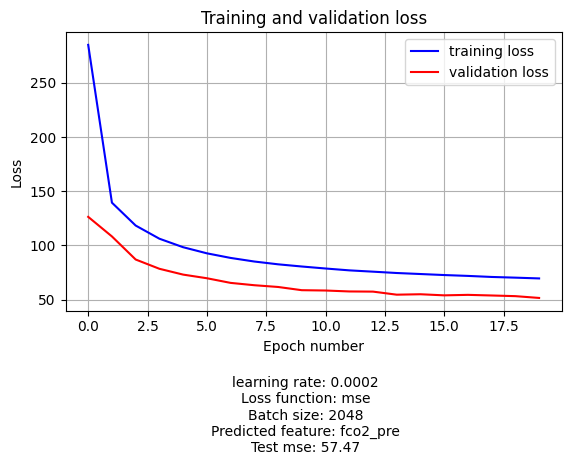

In [38]:
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: {feature_to_predict}\nTest mse: {mse:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/perceptron/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [12]:
# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

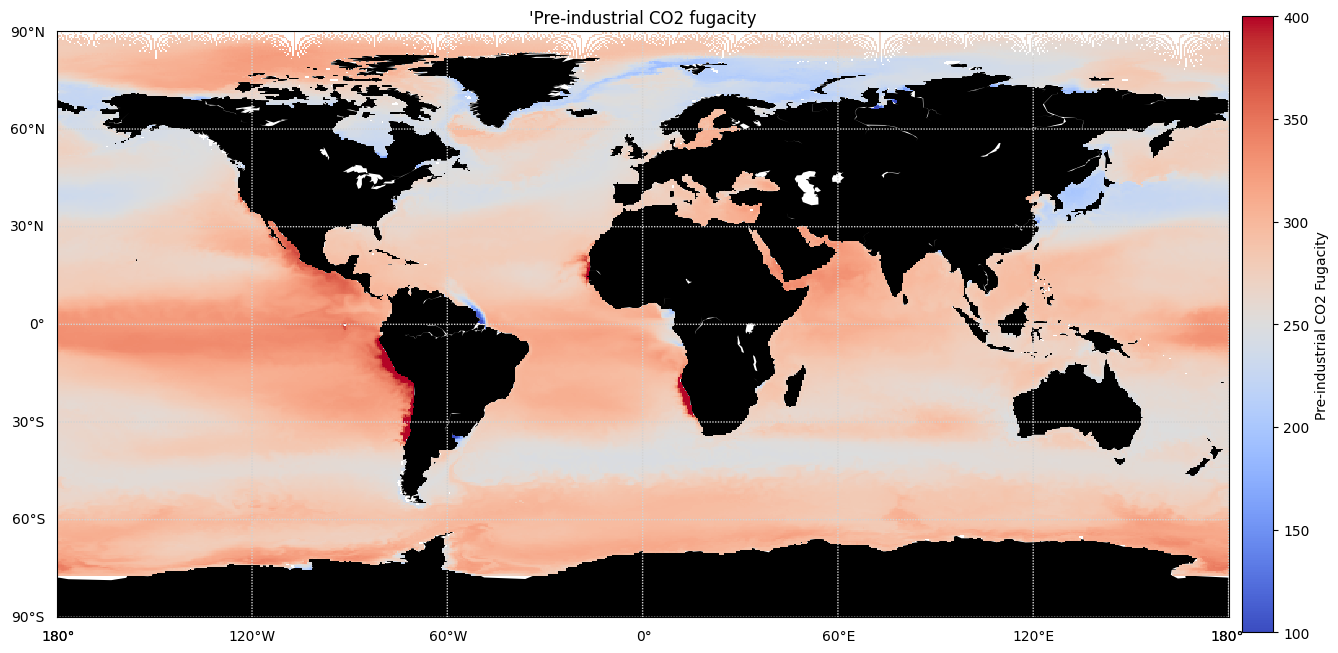

In [13]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = row['prediction']

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='100', vmax='400', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

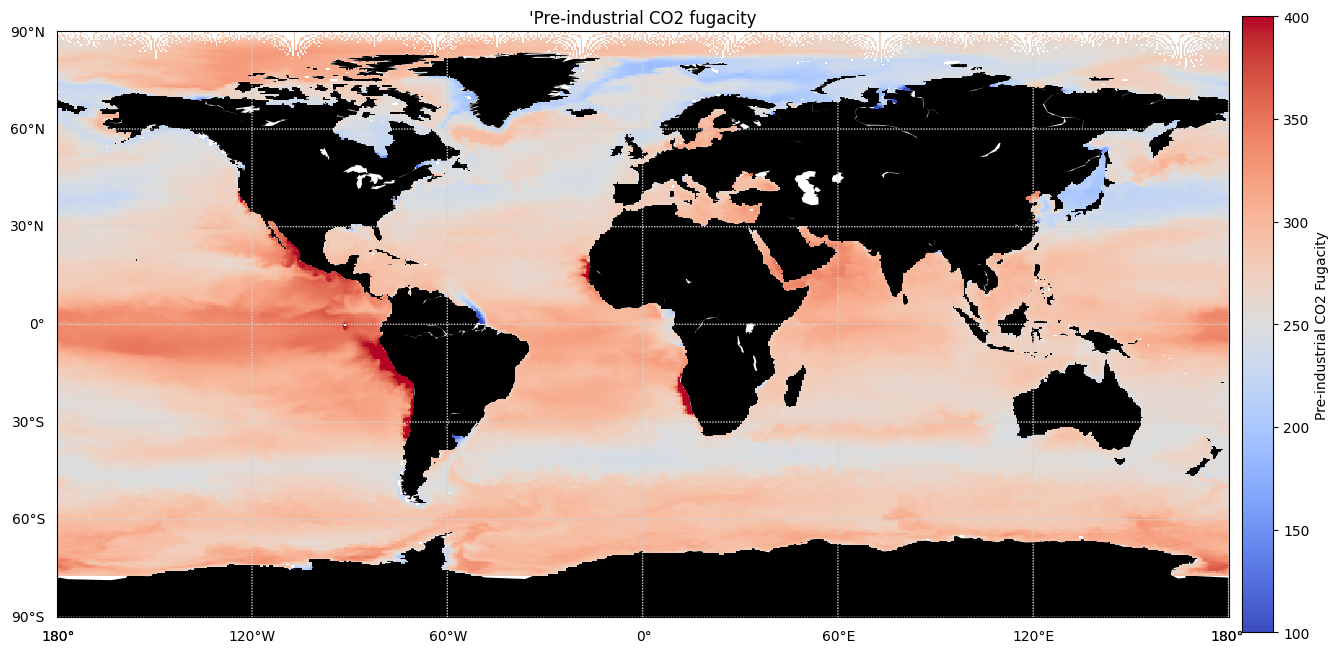

In [14]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = row[feature_to_predict]

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='100', vmax='400', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

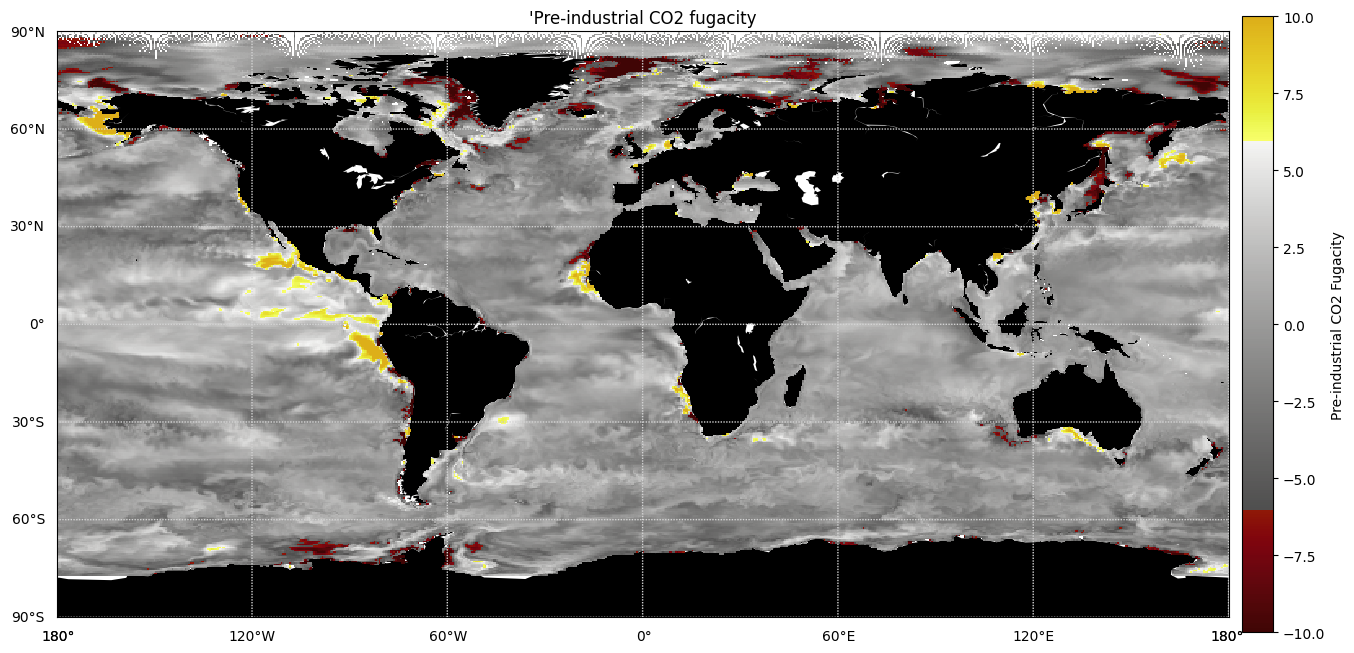

In [15]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = (row[feature_to_predict]-row['prediction'])/row[feature_to_predict]*100

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='-10', vmax='10', cmap=cmocean.cm.oxy, shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

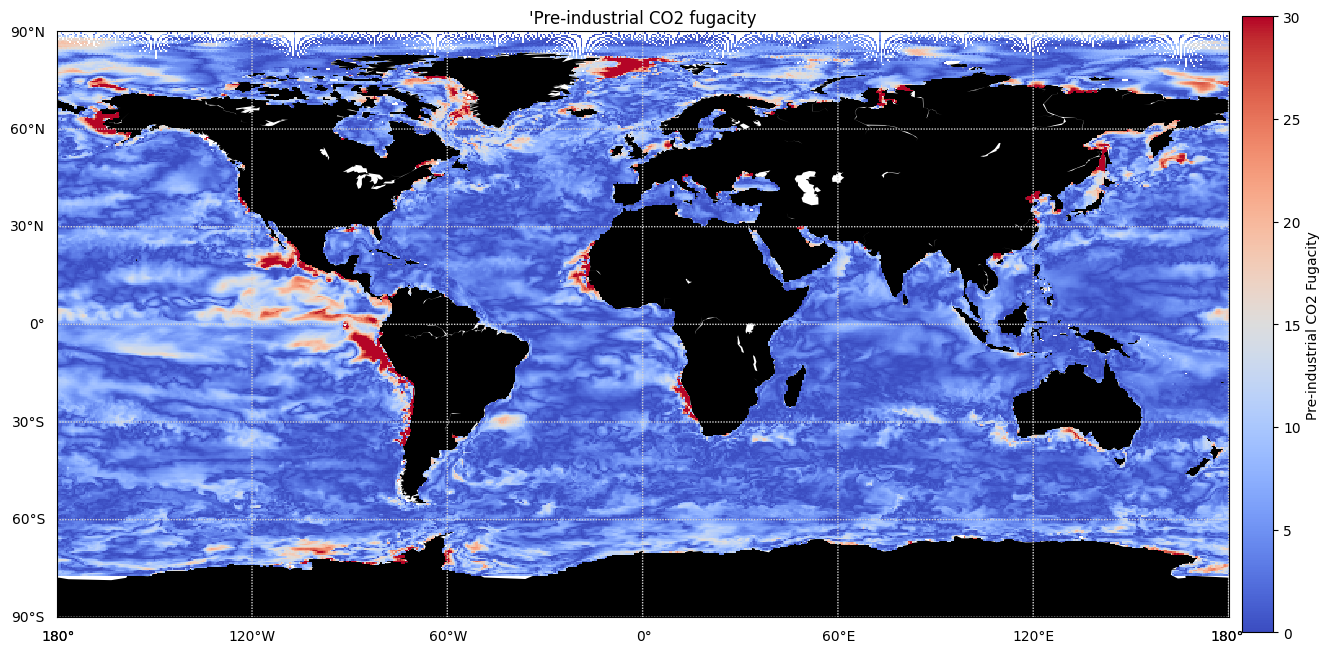

In [16]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = abs(row[feature_to_predict]-row['prediction'])

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='0', vmax='30', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

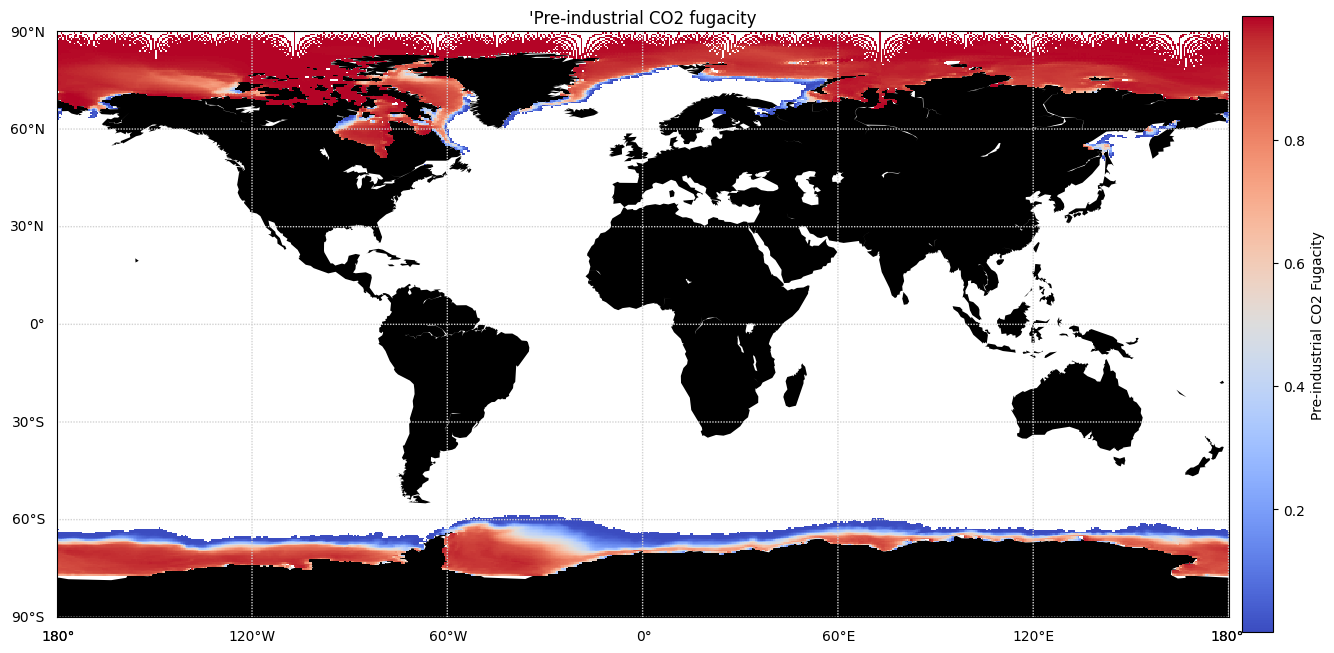

In [18]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_input.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = abs(row['ice_frac'])

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data, cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()